In [36]:
import pickle
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import CrossEncoder, InputExample, losses, SentenceTransformer, util
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import sys

In [3]:
import pickle 
import pandas as pd
import spacy
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
tqdm.pandas()
import re
import transformers
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk import tokenize
import pickle
import urllib.request as requests
import json
import statistics
import torch
from collections import defaultdict
import copy
import math

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
nltk.download('punkt')
nlp = spacy.load("en_core_web_lg")
model = SentenceTransformer('all-mpnet-base-v2')

df=pd.read_csv('gmo_to_uniqueId.csv')
materialID=df['lastRunJob'].to_list()

with open('PreProcessed_segmented.pkl', 'rb') as f:
    newmetalist=pickle.load(f)

sampled_datadf=pd.read_csv("Sampled_Adword_Labeled.csv")

#For Normal process with target labels only

df1=pd.read_csv('ChildAdwordTargetDatabase.csv')
target_dict=dict(zip(df1['Name'], df1.index))

[nltk_data] Downloading package punkt to /Users/haskar140/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
sampled_datadf.head()

,Unnamed: 0.1,Unnamed: 0,materialId,lastRunJob,materialtitle,seriestitle,AssetCC,adword
0,665,665,GMO_00000000040741_01,FILE_MAF_20210731T020535Z_GMO_00000000040741_01,I KNEW YOU WHEN,friday night lights,"LKS, IS IS SLAMMIN' SAMMY MEADE,\nFO [radio]\n...",Sports
1,8244,8244,GMO_00000000370441_01,FILE_MAF_20220215T090159Z_GMO_00000000370441_01,Make Up or Break Up?,total bellas,>> NIKKI: Yeah! Welcome to Paris! Tonight on t...,Sports
2,678,678,GMO_00000000039091_01,FILE_MAF_20220213T121447Z_GMO_00000000039091_01,HOMECOMING (EDITED),friday night lights,"What's after\nhigh school, Brian? Me and Mack ...",Sports
3,777,777,GMO_00000000039094_01,FILE_MAF_20220213T173625Z_GMO_00000000039094_01,NEVERMIND (EDITED),friday night lights,"Here's to God in ten years from now, Street, g...",Sports
4,679,679,GMO_00000000039095_01,FILE_MAF_20220213T173619Z_GMO_00000000039095_01,WHAT TO DO WHILE YOU'RE WAITING (EDITED),friday night lights,"Dad? You're home! Hello, Brian. Waverly? Damn,...",Sports


In [7]:
newmetalist[0]

[['  just want to tell you that I appreciate you patch thing up with he .',
  'I would do anything for the woman that I love .',
  'they be go to come at we any way they can and when they do it be not go to be about heat sensor it be go to be about you .',
  'I know I be not the only guy in that company that know those sensor be faulty .',
  'I be sorry what be it you need again all the maintenance work order from the past six month .',
  'I can not let you have that without authorization .',
  'have you hear of the national transportation safety board evan that be your secretary unlawfully gather evidence which mean there will be no settlement of any kind .',
  'and tomorrow I be send this to the district attorney .',
  'your whole story about how louis get his name on the door be bullshit .',
  'jeff .',
  'it be over jessica .',
  'we be do .',
  'I can not believe you actually get they to admit what they do .',
  'you well believe it because it be happen and it would not be happen 

In [11]:
passages=[]
for i in tqdm(range(len(newmetalist))):
    for j in range(len(newmetalist[i])):
        temp=" ".join(newmetalist[i][j])
        passages.append(temp)

  0%|          | 0/8401 [00:00<?, ?it/s]

In [25]:
print(len(passages))

43982


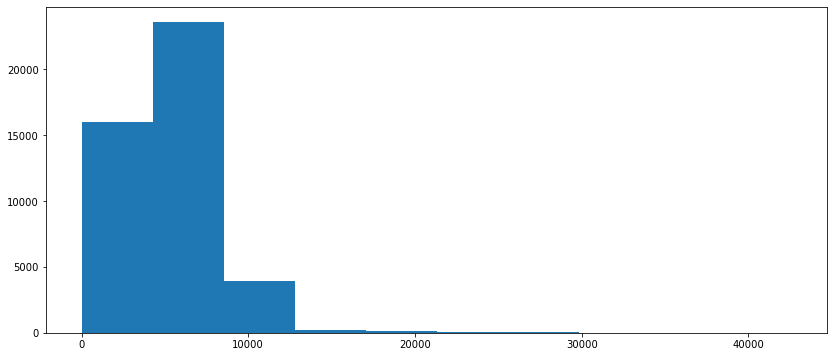

In [22]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.hist([len(passage) for passage in passages]);

In [32]:
def generate_questions(
    tokenizer: AutoTokenizer, model: AutoModelForSeq2SeqLM, passages: list[str],
    batch_size: int=32, device: str="cuda", n_ques_per_passage: int = 3
) -> list[str]:

    outputs = []
    n_batches = len(passages) // batch_size + int(len(passages) % batch_size != 0)

    for n in tqdm(range(n_batches)):
        passages_batch = passages[n*batch_size: (n+1)*batch_size]
        inputs = tokenizer(passages_batch, padding=True, truncation=True,
                           max_length=512, return_tensors="pt")
        output = model.generate(
            input_ids=inputs['input_ids'].to(device),
            attention_mask=inputs['attention_mask'].to(device),
            max_length=64,
            do_sample=True,
            top_p=0.9,
            num_return_sequences=n_ques_per_passage
        )
        outputs += output

    questions = [tokenizer.decode(txt, skip_special_tokens=True) for txt in outputs]
    return questions

In [30]:
model_name = "doc2query/msmarco-t5-base-v1"

doc2q_tokenizer = AutoTokenizer.from_pretrained(model_name)
doc2q_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [37]:
from wsgiref.simple_server import sys_version


print(sys_version)

CPython/3.9.12


In [33]:
n_ques_per_passage = 3
questions = generate_questions(
    doc2q_tokenizer, doc2q_model, passages, n_ques_per_passage=n_ques_per_passage
)

  0%|          | 0/1375 [00:00<?, ?it/s]


AssertionError: Torch not compiled with CUDA enabled